/home/janik.fechtelpeter/.conda/envs/reallaborai4u/lib/python3.10/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


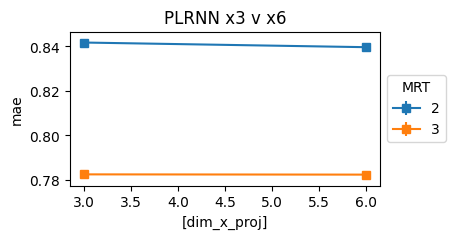

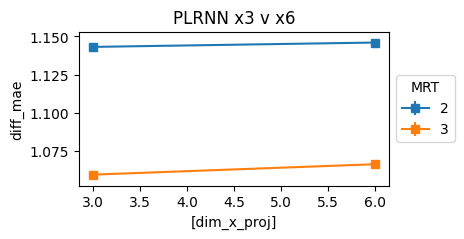

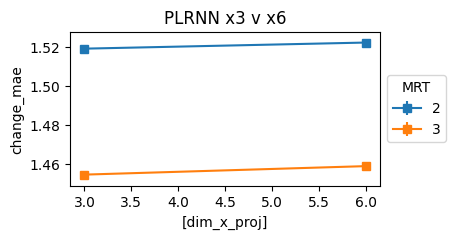

In [2]:
''' 
    Get just the evaluation plot you want. Plots a metric mean (with standard error)
    across all models that fulfil a desired combination of hyperparameters.
    x_axis:     Hyperparameter to plot on the x-axis
    curves:     String or List of hyperparameters to plot as different curves
    include_hyper: Dict with entries hyperparameter:value, only models that have this
                    hyperparameter-value combination will be included in the plot
    exclude_hyper: Dict with entries hyperparameter:value, models that have this
                    hyperparameter-value combination will be excluded from the plot
    horizontal_bar: Float or None. If float, a horizontal bar at this value will be drawn into the plot
    legend_labels: List of labels for the legend. If empty, the column names from results.csv will be used
    legend_title: Str or None. Specifies the title of the legend.
    fig_kwargs: kwargs passed to plt.subplots()
    ax_kwargs:  kwargs passed to dataframe.plot()
'''

import sys
import os
sys.path.append('/home/janik.fechtelpeter/Documents/ordinal-bptt')
sys.path.append('D:/ZI Mannheim/KI Reallabor/ordinal-bptt')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import eval_reallabor_utils
from data_utils import join_ordinal_bptt_path
import plotting_styles as crc

eval_dir = join_ordinal_bptt_path('results/_PLRNN_x6_x3/00_summary')
name = 'PLRNN x3 v x6'
file_formats = ['png']
rename_hypers = {
                #  'MovingAverage(1)': 'Last Step',
                #  'MovingAverage(6)': 'Last Day Average',
                #  'InputsRegression': 'Linear Regression',
                #  'MeanPredictor': 'Global Mean'
                 }
x_axis = ['dim_x_proj']
x_ticks_order = None#[40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140]#['Linear Regression', 'VAR1', 'KalmanFilter', 'PLRNN'] #['Last Step', 'Last Day Average', 'Global Mean', ]
curves = ['MRT']
metrics = ['mae', 'diff_mae', 'change_mae']
ci = 'sem'
sources_of_variance = []
include_hyper = {}#{'model':'PLRNN'}#{'participant': [15, 17, 28, 34, 35, 52, 57, 61, 62]}
exclude_hyper = {'feature': ['EMA_emotion_control', 'EMA_emotion_change']}#, 'Version':'PLRNN (Val Error)'}

prediction_outlier_threshold = 14
# metric_outlier_threshold = {'mae':1.5}

fig_kwargs = {}
plot_kwargs = {
               'kind':'line', 
               #'ylabel':'MAE', 
            #    'xlabel':'dim_p',
            #    'xlim':(50,260),
               'logy':False,
               'marker':'s', 
            #    'linestyle':'', 
               'title':name, 
               'legend':True,
               'figsize':(4, 2),
            #    'color':'blue'
               }
xticks_kwargs = {
                # 'ticks': np.arange(len(x_ticks_order)),
                # 'labels': x_ticks_order,
                # 'fontsize': 'small',
                # 'rotation': 90
               }
legend_kwargs = {
                # 'labels': ['last step', 'last day average', 'linear regression', 'VAR (1)', 'Kalman filter', 'PLRNN']
                }
color_version = None
calc_anova = False
legend_bbox = (1, 0.5)
extend_ylim = True


### Calculations ###

results = pd.read_csv(os.path.join(eval_dir, 'evaluation.csv'), index_col=0)
results = eval_reallabor_utils.include_exclude_hypers(results, include_hyper, exclude_hyper)  

if not isinstance(curves, list):
    curves = [curves]

if calc_anova:
    anova_tables = eval_reallabor_utils.anova_metrics(results, [*x_axis, *curves], metrics, sources_of_variance)
    for i, m in enumerate(metrics):
        print(f'ANOVA for {m}')
        print(anova_tables[i])

metric_values, errorbars = eval_reallabor_utils.calculate_metrics(
    results, [*x_axis, *curves], metrics, sources_of_variance=sources_of_variance, ci=ci, outlier_threshold=prediction_outlier_threshold)

if len(rename_hypers)>0:
    metric_values = metric_values.rename(index=rename_hypers)
    if errorbars is not None:
        errorbars = errorbars.rename(index=rename_hypers)

if x_ticks_order is not None:
    metric_values = metric_values.loc[x_ticks_order]
    if errorbars is not None:
        errorbars = errorbars.loc[x_ticks_order]

for m in metrics:
    this_metric_values = metric_values[m]
    this_errorbars = errorbars[m]
    ### METRIC OUTLIERS CANNOT BE REMOVED PROPERLY, THIS CLASHES WITH XTICKS
    # if isinstance(metric_outlier_threshold, dict) and (m in metric_outlier_threshold.keys()):
    #     outliers = this_metric_values > metric_outlier_threshold[m]
    #     this_metric_values = this_metric_values.loc[~outliers]
    #     this_errorbars = this_errorbars.loc[~outliers]

    m_unstacked = this_metric_values.unstack(curves)
    if this_errorbars is not None:
        e_unstacked = this_errorbars.unstack(curves)
    else:
        e_unstacked = None
    
    fig, ax = plt.subplots(1, 1, **fig_kwargs)
    default_ax_kwargs = {'yerr': e_unstacked, 'kind': 'bar', 'xlabel': x_axis, 'ylabel':str(m)}
    if x_axis=='steps':
        default_ax_kwargs['kind'] = 'line'
    for key, value in plot_kwargs.items():
        default_ax_kwargs[key] = value
    if default_ax_kwargs['kind'] == 'bar' and 'linestyle' in default_ax_kwargs:
        default_ax_kwargs.pop('linestyle')
    if default_ax_kwargs['kind'] == 'bar' and 'marker' in default_ax_kwargs:
        default_ax_kwargs.pop('marker')
    T = range(1, len(m_unstacked)+1)
    if color_version is not None:
        default_ax_kwargs['color'] = crc.colors.item_color_codes(m_unstacked.index, version=color_version)
    ax = m_unstacked.plot(ax=ax, **default_ax_kwargs)
    if legend_bbox is not None:
        hdls, lbls = ax.get_legend_handles_labels()
        ax.legend(hdls, lbls, bbox_to_anchor=legend_bbox, loc='center left', title=ax.get_legend().get_title().get_text())
    if len(xticks_kwargs) > 0:
        ax.set_xticks(**xticks_kwargs)
    if extend_ylim:
        ylim = np.array(ax.get_ylim())
        ax.set_ylim(ylim + np.hstack([np.diff(-ylim)*0.03, np.diff(ylim)*0.03]))
    # for c in m_unstacked.columns: 
    #     ax.fill_between(T, m_unstacked[c]-e_unstacked[c], m_unstacked[c]+e_unstacked[c], alpha=0.3)

    if name is not None:
        for ff in file_formats:
            fig.savefig(os.path.join(eval_dir, m+'_'+name+'.'+ff))
    
    # print(f'{sum(outliers)} metric outliers excluded for {m}.')

if name is not None:
    shutil.copyfile(join_ordinal_bptt_path('eval_reallabor/specific_eval_plot.ipynb'),
                    os.path.join(eval_dir, name+'.ipynb'))